In [1]:
# standard lib imports
from collections import defaultdict, Counter
from datetime import datetime
from email.header import decode_header
from email.iterators import *
from email.iterators import _structure
from email.parser import HeaderParser
from email.utils import parsedate_tz, mktime_tz
import html
from mailbox import mbox
import os

# third party imports
from bs4 import BeautifulSoup
import contractions
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from pprint import pprint
import re
import seaborn as sns

# disable warnings from libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/ray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ray/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ray/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
msg_time_to_ts = lambda m: mktime_tz(parsedate_tz(m['Date']))

In [3]:
workdir = "<masked out>"

In [4]:
opened_mails = mbox(os.path.join(workdir, 'Opened.mbox'), create=False)

In [5]:
opened_mail_list = list(opened_mails)

In [6]:
len(opened_mail_list)

2017

In [7]:
opened_mail_list.sort(key=msg_time_to_ts, reverse=True)

In [8]:
msg_datetime_cutoff = datetime.fromisoformat('2020-06-01').timestamp()
opened_mail_list = list(filter(lambda m: msg_time_to_ts(m) > msg_datetime_cutoff, opened_mail_list))

In [9]:
len(opened_mail_list)

1346

In [10]:
# now we clean data for unread mails
unread_mail_list = list(mbox(os.path.join(workdir, 'Unread.mbox'), create=False))

In [11]:
len(unread_mail_list)

5361

In [12]:
unread_mail_list = list(filter(lambda m: m["Date"], unread_mail_list))

In [13]:
len(unread_mail_list)

5360

In [14]:
unread_mail_list.sort(key=msg_time_to_ts, reverse=True)

In [15]:
unread_mail_list = list(filter(lambda m: msg_time_to_ts(m) > msg_datetime_cutoff, unread_mail_list))

In [16]:
len(unread_mail_list)

4126

In [ ]:
list(map(lambda m: m["Subject"], unread_mail_list[:20]))

In [22]:
def collapse_threads_and_filter_self_sent(mail_list):
    # for emails in the same thread, only use the first email
    mail_threads = defaultdict(list)
    for msg in mail_list:
        g_thrid = msg["X-GM-THRID"]
        mail_threads[g_thrid].append(msg)
    mail_list = [msgs[-1] for msgs in mail_threads.values()]
    # also filter out sent by me
    mail_list = list(filter(lambda m: "<masked out>" not in m["From"], mail_list))
    mail_list = list(filter(lambda m: "<masked out>" not in m["From"], mail_list))
    return mail_list

In [23]:
opened_mail_list = collapse_threads_and_filter_self_sent(opened_mail_list)
unread_mail_list = collapse_threads_and_filter_self_sent(unread_mail_list)

### now we can try to extract features from the positive (read) and negative (unread) examples
1. sender's domain
2. number of urls in email subject
3. number of urls in email body
4. number of attachments
5. tf-idf from subject
6. tf-idf from body
7. whether there's a thread to the message

In [25]:
# helper functions to clean up raw text
def has_zh_cn(text):
    # because most of my emails are english, it suffices to just check if there's any chinese in the email
    # i'll check all email with chinese in
    return re.search(r"[\u4e00-\u9FFF]", text) is not None

def break_hyphens(text):
    pat = r"-"
    return re.sub(pat, " ", text)

def remove_special_chars(text):
    pat = r"[^a-zA-Z0-9\s]"
    return re.sub(pat, '', text)


def is_url(text):
    pat = r"(https?://)?(www\.)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+[^\s]*"
    return re.search(pat, text) is not None


def is_email(text):
    pat = r"[^\s]+@[^\s]+"
    return re.search(pat, text) is not None


def clean_english(text):
    sw = stopwords.words("english")
    text = contractions.fix(text)
    text = break_hyphens(text)
    lowered_text = map(lambda w: w.strip().lower(), text.split())
    
    url_encoded_text = map(lambda w: "<URL>" if is_url(w) else w, lowered_text)
    email_encoded_text = map(lambda w: "<EMAIL>" if is_email(w) else w, url_encoded_text)
    
    text = map(lambda w: remove_special_chars(w) if w not in ("<URL>", "<EMAIL>") else w, email_encoded_text)
    text = map(lambda w: "<NUM>" if w.isdecimal() else w, text)
    filtered_text = filter(lambda w: w and w not in sw, text)
    return " ".join([wnl.lemmatize(w) for w in filtered_text])
    

In [27]:
# helper functions to parse text features
links_regex_str = r'<a[^>]+href=[^>]+>'

def count_ccs(msg):
    count = 0
    if "Cc" in msg:
        count += len(msg["Cc"].split())
    if "Bcc" in msg:
        count += len(msg["Bcc"].split())
    return count

def count_links(msg):
    count = 0
    for subpart in typed_subpart_iterator(msg, subtype='html'):
        count += len(re.findall(r'<a[^>]+href=[^>]+>', subpart.get_payload()))
    return count

def parse_msg_body_from_html(msg):
    soup = BeautifulSoup(msg)
    for script in soup(["script", "style"]):
        script.decompose()
    for pre in soup(["pre"]):
        pre.decompose()
    raw_text = soup.get_text(" ", strip=True)
    return clean_english(raw_text), has_zh_cn(raw_text)

def get_body(msg):
    body = []
    has_cn = False
    
    # prioritize html since it's easier to parse
    for subpart in typed_subpart_iterator(msg, subtype='html'):
        msg_part_str = subpart.get_payload(decode=True).decode('utf-8', errors="ignore")
        
        cleaned_text, has_cn = parse_msg_body_from_html(msg_part_str)
        body.append(cleaned_text)
        
    if not body:
        #try html files
        for subpart in typed_subpart_iterator(msg, subtype='plain'):
            msg_part_str = subpart.get_payload(decode=True).decode('utf-8', errors="ignore")

            cleaned_text, has_cn = parse_msg_body_from_html(msg_part_str) # although not an html document per se, useful for getting rid of the html special chars
            body.append(cleaned_text)
            
    if sum(map(lambda b: len(b), body)) > 10000:
        print(f"Oversized message from={msg['From']} subject={msg['Subject']}")
    return ' '.join(body), 1 if has_cn else 0

def decode_header_field(s):
    b_str, encoding = decode_header(s)[0]
    if not encoding:
        return s
    return b_str.decode(encoding)

def get_subject(msg):
    raw_text = decode_header_field(msg["Subject"])
    # remove all emoji
    pat = r"=\?UTF-8\?.*\?="
    text = re.sub(pat, '', raw_text)
    return clean_english(text), 1 if has_zh_cn(text) else 0

def count_attachments(msg):
    count = 0
    for subpart in typed_subpart_iterator(msg, maintype='application'):
        count += 1
    return count

In [ ]:
all_samples = opened_mail_list + unread_mail_list
all_labels = [1 for _ in opened_mail_list] + [0 for _ in unread_mail_list]

froms = [m["From"] for m in all_samples] # strings
subjects, subject_has_cn = zip(*[get_subject(m) for m in all_samples]) # strings
num_ccs = [count_ccs(m) for m in all_samples] # numbers
num_links = [count_links(m) for m in all_samples] # numbers
bodies, body_has_cn = zip(*[get_body(m) for m in all_samples]) # strings
num_attachments = [count_attachments(m) for m in all_samples] # numbers

In [29]:
# perhaps we should split the from to 3 different features
# 1. if the address is resolveable or not
# 2. email username
# 3. domain name

pattern = re.compile(r"^(?P<alias>[^\<\>]*)\s?<?(?P<usr>[^<\s]*)@(?P<domain>[^>\s]*)>?")

all_matches = [pattern.search(f) for f in froms]

all_alias, all_usr, all_domain = [], [], []

for i, match in enumerate(all_matches):
    try:
        alias, usr, domain = match.group("alias").strip(), match.group("usr"), match.group("domain")
        all_alias.append(decode_header_field(alias))
        all_usr.append(usr)
        all_domain.append(domain)
    except Exception as e:
        print(e)
        print(froms[i])
        print()

In [33]:
numerical_df = pd.DataFrame(data={
    "num_ccs": num_ccs,
    "num_links": num_links,
    "num_attachments": num_attachments,
    "read": all_labels
})

In [34]:
numerical_df.dtypes

num_ccs            int64
num_links          int64
num_attachments    int64
read               int64
dtype: object

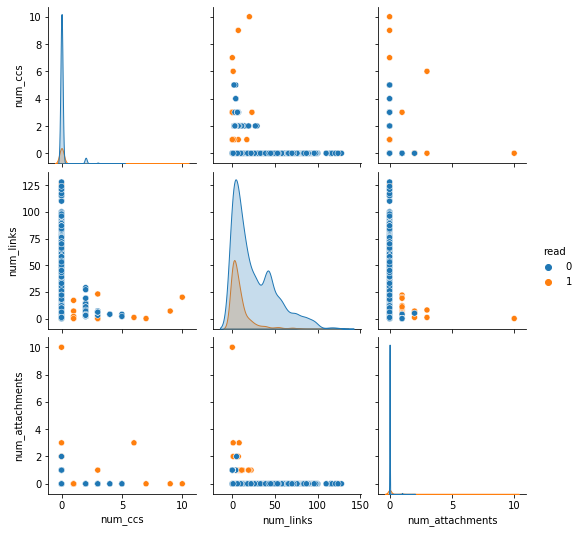

In [35]:
sns.pairplot(numerical_df, hue="read")

In [36]:
"""
we can see the two classes is roughly separable on all 3 dimensions

now we'll extract bag of words features from subject and body
"""
data_df = pd.DataFrame({
    "gmail_alias": all_alias,
    "usrname": all_usr,
    "domain": all_domain,
    "subject": subjects,
    "body": bodies,
    "num_ccs": num_ccs,
    "num_urls": num_links,
    "num_attachments": num_attachments,
    "label": all_labels
})

In [37]:
len(data_df)

4489

In [ ]:
data_df.head()

In [40]:
# Since we found some duplicated emails with different labels, we deduplicate the samples by
# taking the average of the labels for all the occurrences of the same email and round 
# to the nearest int (either 0 or 1)
deduped_df = data_df.groupby(data_df.columns.values.tolist()[:-1]).mean().apply(np.rint).reset_index()

In [68]:
deduped_df.to_csv("<masked out>")